# 出力値の確認

- AP計算時のテーブル
- 細かく見たときのプロット

In [3]:
import sys, os
sys.path.append(os.pardir)

In [71]:
from pathlib import Path
import numpy as np
import polars as pl
import os
from hydra import initialize, compose

from src.utils.common import trace

with initialize(config_path="../run/conf", version_base=None):
    cfg = compose("cv_train", overrides=["exp_name=exp013"])

In [5]:
# series の読み込み
train_df = pl.read_parquet(Path(cfg.dir.data_dir) / "train_series.parquet")
train_df = train_df.with_columns(
            pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z")
        )
event_df = pl.read_csv(Path(cfg.dir.data_dir) / "train_events.csv").drop_nulls()
event_df = event_df.with_columns(
    pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z")
)

In [6]:
exp_dir = Path(os.path.join(cfg.dir.cv_model_dir, cfg.exp_name, "cv"))
oof_event_df_list = []
for fold in range(cfg.num_fold):
    oof_event_df_list.append(pl.read_csv(exp_dir / f"val_pred_df_fold{fold}.csv"))
oof_event_df = pl.concat(oof_event_df_list)

In [52]:
"""Event Detection Average Precision

An average precision metric for event detection in time series and
video.

"""

from bisect import bisect_left
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import concurrent.futures

class ParticipantVisibleError(Exception):
    pass


# Set some placeholders for global parameters
series_id_column_name = "series_id"
time_column_name = "step"
event_column_name = "event"
score_column_name = "score"
use_scoring_intervals = False
tolerances = {
    "onset": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
    "wakeup": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
}


def score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    tolerances: Dict[str, List[float]],
    series_id_column_name: str,
    time_column_name: str,
    event_column_name: str,
    score_column_name: str,
    use_scoring_intervals: bool = False,
) -> float:
    # Validate metric parameters
    assert len(tolerances) > 0, "Events must have defined tolerances."
    assert set(tolerances.keys()) == set(solution[event_column_name]).difference({"start", "end"}), (
        f"Solution column {event_column_name} must contain the same events " "as defined in tolerances."
    )
    assert pd.api.types.is_numeric_dtype(
        solution[time_column_name]
    ), f"Solution column {time_column_name} must be of numeric type."

    # Validate submission format
    for column_name in [
        series_id_column_name,
        time_column_name,
        event_column_name,
        score_column_name,
    ]:
        if column_name not in submission.columns:
            raise ParticipantVisibleError(f"Submission must have column '{column_name}'.")

    if not pd.api.types.is_numeric_dtype(submission[time_column_name]):
        raise ParticipantVisibleError(f"Submission column '{time_column_name}' must be of numeric type.")
    if not pd.api.types.is_numeric_dtype(submission[score_column_name]):
        raise ParticipantVisibleError(f"Submission column '{score_column_name}' must be of numeric type.")

    # Set these globally to avoid passing around a bunch of arguments
    globals()["series_id_column_name"] = series_id_column_name
    globals()["time_column_name"] = time_column_name
    globals()["event_column_name"] = event_column_name
    globals()["score_column_name"] = score_column_name
    globals()["use_scoring_intervals"] = use_scoring_intervals

    return event_detection_ap(solution, submission, tolerances)

def event_detection_ap(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    tolerances: Dict[str, List[float]] = tolerances,
) -> float:
    # Ensure solution and submission are sorted properly
    solution = solution.sort_values([series_id_column_name, time_column_name])
    submission = submission.sort_values([series_id_column_name, time_column_name])

    # Extract scoring intervals.
    if use_scoring_intervals:
        pass

    # Extract ground-truth events.
    ground_truths = solution.query("event not in ['start', 'end']").reset_index(drop=True)

    # Map each event class to its prevalence (needed for recall calculation)
    class_counts = ground_truths.value_counts(event_column_name).to_dict()

    # Create table for detections with a column indicating a match to a ground-truth event
    detections = submission.assign(matched=False)

    # Remove detections outside of scoring intervals
    if use_scoring_intervals:
        # detections_filtered = []
        # for (det_group, dets), (int_group, ints) in zip(
        #     detections.groupby(series_id_column_name), intervals.groupby(series_id_column_name)
        # ):
        #     assert det_group == int_group
        #     detections_filtered.append(filter_detections(dets, ints))  # noqa: F821
        # detections_filtered = pd.concat(detections_filtered, ignore_index=True)
        pass
    else:
        detections_filtered = detections

    # Create table of event-class x tolerance x series_id values
    aggregation_keys = pd.DataFrame(
        [
            (ev, tol, vid)
            for ev in tolerances.keys()
            for tol in tolerances[ev]
            for vid in ground_truths[series_id_column_name].unique()
        ],
        columns=[event_column_name, "tolerance", series_id_column_name],
    )


    # Create match evaluation groups: event-class x tolerance x series_id
    detections_grouped = aggregation_keys.merge(
        detections_filtered, on=[event_column_name, series_id_column_name], how="left"
    ).groupby([event_column_name, "tolerance", series_id_column_name])
    ground_truths_grouped = aggregation_keys.merge(
        ground_truths, on=[event_column_name, series_id_column_name], how="left"
    ).groupby([event_column_name, "tolerance", series_id_column_name])
    
    # Match detections to ground truth events by evaluation group
    detections_matched = []
    for key in tqdm(aggregation_keys.itertuples(index=False)):
        dets = detections_grouped.get_group(key)
        gts = ground_truths_grouped.get_group(key)
        detections_matched.append(match_detections(dets["tolerance"].iloc[0], gts, dets))
    detections_matched = pd.concat(detections_matched)
    """

    def match_wrapper(key, detections_grouped, ground_truths_grouped):
        dets = detections_grouped.get_group(key)
        gts = ground_truths_grouped.get_group(key)
        return match_detections(dets["tolerance"].iloc[0], gts, dets)
    
    with trace("match"):
        detections_matched = []

        with concurrent.futures.ThreadPoolExecutor() as executor:
            # 各キーに対して並列処理を実行
            futures = [executor.submit(match_wrapper, key, detections_grouped, ground_truths_grouped) for key in aggregation_keys.itertuples(index=False)]
            for future in concurrent.futures.as_completed(futures):
                detections_matched.append(future.result())

        detections_matched = pd.concat(detections_matched)
    """
    print(class_counts)
    with trace("Compute AP per event x tolerance group"):
        # Compute AP per event x tolerance group
        event_classes = ground_truths[event_column_name].unique()
        ap_table = (
            detections_matched.query("event in @event_classes")  # type: ignore
            .groupby([event_column_name, "tolerance"])
            .apply(
                lambda group: average_precision_score_with(
                    group["matched"].to_numpy(),
                    group[score_column_name].to_numpy(),
                    class_counts[group[event_column_name].iat[0]],
                )
            )
        )
        
    # Average over tolerances, then over event classes
    mean_ap = ap_table.groupby(event_column_name)['ap'].mean().sum() / len(event_classes)

    return mean_ap, ap_table


def find_nearest_time_idx(times, target_time, excluded_indices, tolerance):
    """Find the index of the nearest time to the target_time
    that is not in excluded_indices."""
    idx = bisect_left(times, target_time)

    best_idx = None
    best_error = float("inf")

    offset_range = min(len(times), tolerance)
    for offset in range(-offset_range, offset_range):  # Check the exact, one before, and one after
        check_idx = idx + offset
        if 0 <= check_idx < len(times) and check_idx not in excluded_indices:
            error = abs(times[check_idx] - target_time)
            if error < best_error:
                best_error = error
                best_idx = check_idx

    return best_idx, best_error


def match_detections(tolerance: float, ground_truths: pd.DataFrame, detections: pd.DataFrame) -> pd.DataFrame:
    detections_sorted = detections.sort_values(score_column_name, ascending=False).dropna()
    is_matched = np.full_like(detections_sorted[event_column_name], False, dtype=bool)
    ground_truths_times = ground_truths.sort_values(time_column_name)[time_column_name].tolist()
    matched_gt_indices: set[int] = set()

    for i, det in enumerate(detections_sorted.itertuples(index=False)):
        det_time = getattr(det, time_column_name)

        best_idx, best_error = find_nearest_time_idx(ground_truths_times, det_time, matched_gt_indices, tolerance)

        if best_idx is not None and best_error < tolerance:
            is_matched[i] = True
            matched_gt_indices.add(best_idx)

    detections_sorted["matched"] = is_matched
    return detections_sorted


def precision_recall_curve(
    matches: np.ndarray, scores: np.ndarray, p: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if len(matches) == 0:
        return [1], [0], []  # type: ignore

    # Sort matches by decreasing confidence
    idxs = np.argsort(scores, kind="stable")[::-1]
    scores = scores[idxs]
    matches = matches[idxs]

    distinct_value_indices = np.where(np.diff(scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, matches.size - 1]
    thresholds = scores[threshold_idxs]

    # Matches become TPs and non-matches FPs as confidence threshold decreases
    tps = np.cumsum(matches)[threshold_idxs]
    fps = np.cumsum(~matches)[threshold_idxs]

    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = tps / p  # total number of ground truths might be different than total number of matches

    # Stop when full recall attained and reverse the outputs so recall is non-increasing.
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)

    # Final precision is 1 and final recall is 0
    return np.r_[precision[sl], 1], np.r_[recall[sl], 0], thresholds[sl]


def average_precision_score(matches: np.ndarray, scores: np.ndarray, p: int) -> float:
    precision, recall, _ = precision_recall_curve(matches, scores, p)
    # Compute step integral
    return -np.sum(np.diff(recall) * np.array(precision)[:-1])



def average_precision_score_with(matches: np.ndarray, scores: np.ndarray, p: int) -> float:
    precision, recall, _ = precision_recall_curve(matches, scores, p)
    # Compute step integral
    return pd.Series({'ap': -np.sum(np.diff(recall) * np.array(precision)[:-1]), 'precision':precision, "recall":recall})


In [56]:
score, ap_table = event_detection_ap(
    event_df.to_pandas(),
    oof_event_df.to_pandas(),
)
score

0it [00:00, ?it/s]

{'wakeup': 4794, 'onset': 4791}


[7.8GB(+0.0GB):0.4sec] Compute AP per event x tolerance group 


0.7392876263644894

In [57]:
ap_table

ap                                          precision  \
event  tolerance                                                                
onset  12         0.331800  [0.07149399552208427, 0.07149037972106281, 0.0...   
       36         0.644775  [0.10711377976796255, 0.10712104245138959, 0.1...   
       60         0.718383  [0.1153572155505801, 0.11536699582612236, 0.11...   
       90         0.766388  [0.11881742316303684, 0.11882826020563983, 0.1...   
       120        0.785107  [0.11937716262975778, 0.11938817061997353, 0.1...   
       150        0.797936  [0.11958070425401995, 0.11959177440700397, 0.1...   
       180        0.809386  [0.11968247506615103, 0.11969357630051919, 0.1...   
       240        0.824030  [0.12003867290860981, 0.12004988292782245, 0.1...   
       300        0.830823  [0.1202167718298392, 0.12022803624147409, 0.12...   
       360        0.838197  [0.1204711988601669, 0.12048254097526213, 0.12...   
wakeup 12         0.315342  [0.07296011903180381, 0.07298008667216122, 0.0...   
       36         0.662569  [0.10703819725141471, 0.10705891273030556, 0.1...   
       60         0.737779  [0.11534963621665319, 0.11537392271337225, 0.1...   
       90         0.769869  [0.1180022231204527, 0.11802764930371269, 0.11...   
       120        0.790222  [0.11939652979188928, 0.1194075431363567, 0.11...   
       150        0.805112  [0.11962550246781661, 0.11963658573828065, 0.1...   
       180        0.816285  [0.11993079936905307, 0.11994197587417926, 0.1...   
       240        0.834287  [0.12018521345341678, 0.12019646765409478, 0.1...   
       300        0.849236  [0.12041418612934413, 0.12042551025601873, 0.1...   
       360        0.858225  [0.12059227598839872, 0.12060365450195959, 0.1...   

                                                             recall  
event  tolerance                                                     
onset  12         [0.5865163848883322, 0.5863076601962012, 0.586...  
       36         [0.8787309538718431, 0.878522229179712, 0.8785...  
       60         [0.9463577541223127, 0.9461490294301816, 0.946...  
       90         [0.9747443122521394, 0.9745355875600084, 0.974...  
       120        [0.9793362554790231, 0.9791275307868921, 0.979...  
       150        [0.9810060530160718, 0.9807973283239407, 0.980...  
       180        [0.9818409517845961, 0.981632227092465, 0.9816...  
       240        [0.9847630974744312, 0.9845543727823002, 0.984...  
       300        [0.9862241703193487, 0.9860154456272177, 0.986...  
       360        [0.9883114172406595, 0.9881026925485284, 0.988...  
wakeup 12         [0.572799332498957, 0.5725907384230288, 0.5725...  
       36         [0.8838130997079683, 0.8836045056320401, 0.883...  
       60         [0.9524405506883604, 0.9522319566124322, 0.952...  
       90         [0.9743429286608261, 0.9741343345848978, 0.974...  
       120        [0.9789319983312474, 0.9787234042553191, 0.978...  
       150        [0.9808093450146016, 0.9806007509386734, 0.980...  
       180        [0.9833124739257405, 0.9831038798498123, 0.983...  
       240        [0.985398414685023, 0.9851898206090947, 0.9851...  
       300        [0.9872757613683771, 0.9870671672924489, 0.987...  
       360        [0.9887359198998749, 0.9885273258239466, 0.988...

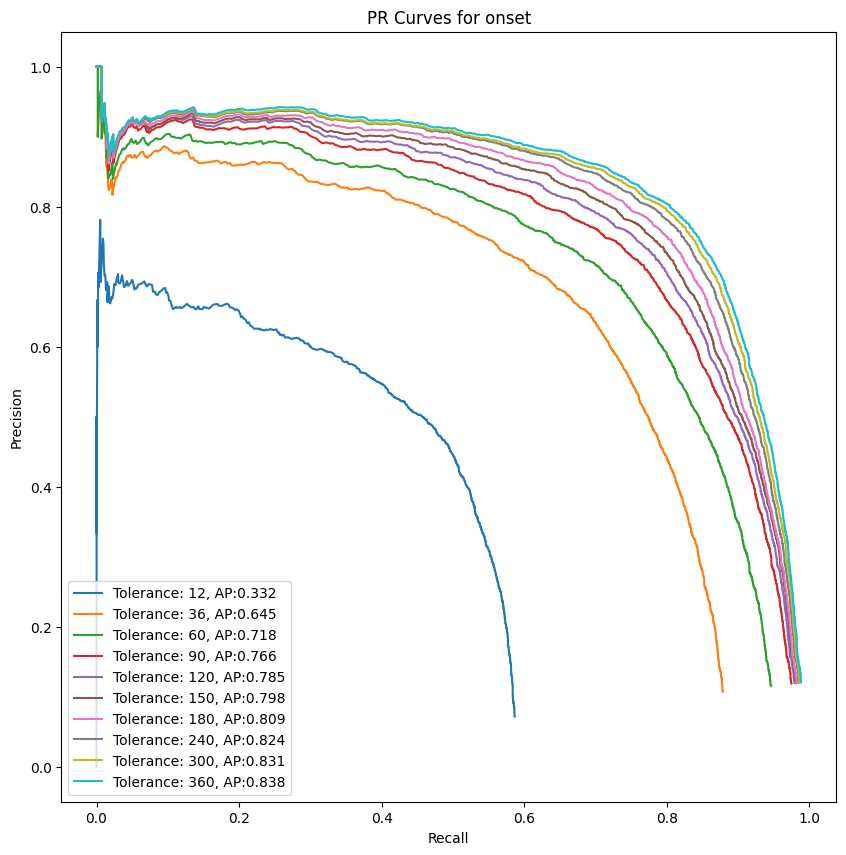

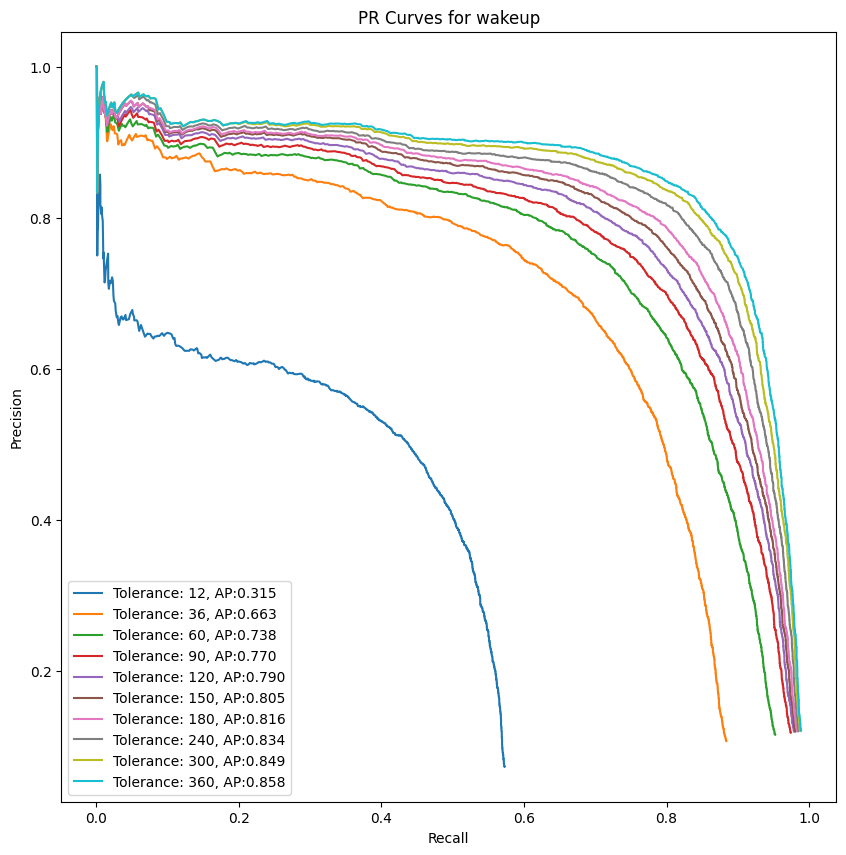

In [81]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


for event in ["onset", "wakeup"]:
    plt.figure(figsize=(10, 10))
    for (event_key, tolerance), group in ap_table[ap_table.index.get_level_values('event') == event].iterrows():
        plt.plot(group['recall'][:-1], group['precision'][:-1], label=f'Tolerance: {tolerance}, AP:{group["ap"]:.3f}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'PR Curves for {event}')
    plt.legend()
    plt.show()
